## Demand Estimation Exercise

In this assignment, you will learn how to simulate market data and estimate simple random coefficient demand models. The assignment should serve as an introduction to the structural estimation in heterogenous product demand models.

Let's first define the model.


In [1]:
import simulate
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
n_firms = 10
n_const = 1000
n_caract = 4
T = 100


market = simulate.Market_Data(n_firms, n_const, n_caract, T)
print(market)

Market with 10 firms and 1000 consumers over 100 time periods. 
 Firms sell differentiated product which have 4 product characteristics


This market is characterized by the following parameters that are unknown to the econometrician:

$\alpha_{\mu} =  0.5$
$\alpha_{\sigma} =  0.05$
These two parameters can be used for the lognormal distribution to find: -1.65 mean of the lognormal with standard deviation




$\beta_{\mu} =  [[1.47435481], [1.41511067] , [1.0707528 ], [2.39841642]]$ 



$\beta_{\sigma} = [[0.02938696], [0.02612406],  [0.00292152],  [0.01330291]]  $



In [3]:
print(market.beta_0)
print(market.beta_sd)
print(market.alpha_0)
print(market.alpha_0_sd)

[[2.43371435]
 [1.36983501]
 [2.20479267]
 [0.30766116]]
[[0.01127675]
 [0.03599258]
 [0.00561194]
 [0.00134334]]
-1.650783460888857
0.006821238081735126


In [4]:
df = market.generate_simulated_data()
print(df)

     market_ids  firm_ids  market_share      price      cost        xi  \
0             1         1  2.187072e-02  20.108883  3.041989 -0.042173   
1             1         2  6.575459e-06  25.265086  3.377494 -0.135383   
2             1         3  4.504882e-12  35.197042  3.517153  0.027024   
3             1         4  1.645797e-06  23.437392  3.278474 -0.032851   
4             1         5  1.476001e-15  37.110564  3.487085  0.219944   
..          ...       ...           ...        ...       ...       ...   
995         100         6  1.411115e-06  19.746588  3.199839 -0.192426   
996         100         7  6.310282e-18  40.632308  3.547763  0.177320   
997         100         8  1.656707e-21  37.738410  3.477627  0.253008   
998         100         9  6.009567e-17  40.893984  3.355681  0.394304   
999         100        10  3.836152e-04  22.717354  3.548116 -0.438902   

        char1     char2     char3     char4  
0    4.084113  3.486695  5.444982  4.720201  
1    5.950637  4.41

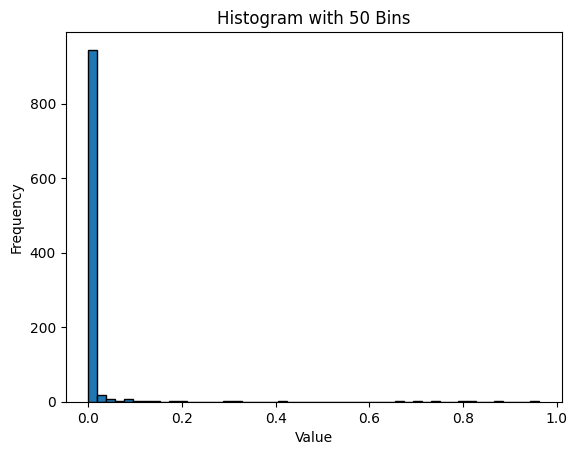

In [12]:
# try the standard probit model for finding the coefficients 
# Generate some random data for the histogram


# Create a histogram with 10 bins
plt.hist(market.market_shares, bins=50, edgecolor='black')

# Set labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with 50 Bins')

# Display the plot
plt.show()

Trying to estimate with the logit function: 
 
y = ln(s_0) - ln(s_n)


In [27]:
reshape = np.reshape(market.market_shares, (T, n_firms))

sum_market_shares = np.sum(reshape, axis=1)
print(sum_market_shares)

outside_good_share = df.groupby('market_ids')['market_share'].sum()
print(outside_good_share)

    

[2.18789425e-02 3.83716171e-03 3.25180245e-05 2.09986125e-01
 1.82446438e-03 2.44108832e-02 1.09448483e-03 2.65594003e-03
 1.19237795e-03 8.03713386e-02 8.76324343e-01 2.73767441e-05
 9.21679116e-06 3.59824222e-05 1.92522083e-04 1.21662174e-02
 1.27313573e-02 7.03782144e-01 2.06396523e-04 1.21505344e-05
 6.61600290e-04 5.42245853e-04 1.67944420e-05 7.74971803e-04
 3.69025838e-02 8.13198780e-06 4.05721646e-02 1.89779468e-03
 2.50657651e-05 4.32356998e-01 3.32101733e-05 9.68463639e-02
 8.53971988e-02 1.28869757e-01 9.62517219e-01 4.36213504e-04
 2.06324746e-01 2.19765551e-02 9.64479278e-02 2.36172030e-01
 2.44197323e-03 2.29450024e-05 7.89504980e-01 8.57040215e-01
 3.81168417e-02 2.95999930e-05 4.96184850e-02 7.14253051e-02
 4.78927067e-04 4.74556863e-04 1.49690466e-01 3.20503927e-07
 1.03283409e-01 8.18405858e-01 2.45853869e-02 1.49442481e-01
 8.19657024e-03 2.12197493e-02 8.73263031e-01 2.96912326e-01
 5.27031784e-03 1.85791585e-02 1.19524488e-02 3.04535690e-01
 6.24660910e-02 6.902710